# REGRESSION

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## Data Loading

In [2]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Exploration

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900


In [4]:
df.shape

(1003, 7)

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1003 non-null   int64  
 1   sex       1003 non-null   object 
 2   bmi       1003 non-null   float64
 3   children  1003 non-null   int64  
 4   smoker    1003 non-null   object 
 5   region    1003 non-null   object 
 6   charges   1003 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 55.0+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.255234,30.511780,1.104686,13267.935817
std,14.039105,6.013107,1.204619,12051.356547
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.210000,0.000000,4780.839400
50%,39.000000,30.200000,1.000000,9447.382400
75%,51.000000,34.430000,2.000000,16840.667970
max,64.000000,53.130000,5.000000,62592.873090


## Data Preprocessing

In [8]:
dummies_df = pd.get_dummies(df)

In [9]:
dummies_df

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,24,23.655,0,2352.96845,0,1,1,0,0,1,0,0
1,28,26.510,2,4340.44090,1,0,1,0,0,0,1,0
2,51,39.700,1,9391.34600,0,1,1,0,0,0,0,1
3,47,36.080,1,42211.13820,0,1,0,1,0,0,1,0
4,46,28.900,2,8823.27900,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
998,18,31.350,4,4561.18850,1,0,1,0,1,0,0,0
999,39,23.870,5,8582.30230,1,0,1,0,0,0,1,0
1000,58,25.175,0,11931.12525,0,1,1,0,1,0,0,0
1001,37,47.600,2,46113.51100,1,0,0,1,0,0,0,1


In [10]:
class EncoderAddDropCol(TransformerMixin,BaseEstimator):
    def __init__(self, dropcols=None):
        """Encode, add, drop columns"""
        self.dropcols=dropcols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        tmp = pd.get_dummies(X, drop_first=True)
        tmp['smoke_bmi'] = tmp['bmi'] * tmp ['smoker_yes']
        if isinstance(self.dropcols,str):
            self.dropcols = [self.dropcols]
        if isinstance(self.dropcols,list):
            tmp = tmp.loc[:,~tmp.columns.str.match('^('+'|'.join(self.dropcols)+')')]
        return tmp

## Insights

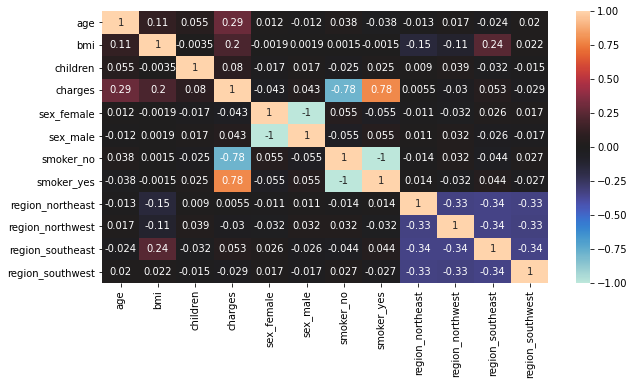

In [11]:
plt.figure(figsize=(10,5))
corr = dummies_df.corr()
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,annot=True)

**Nhận xét:**

Từ biểu đồ heatmap trên ta thấy được các thuộc tính `age`, `bmi`, `smoker` có mối tương quan khá chặt chẽ với `charges`, còn các thuộc tính còn lại thì mối tương quan này khá là yếu. Vì vậy, ta đi phân tích rõ hơn các mối quan tương này ở các bước dưới.

### Relationship between `age` and `charges`

<AxesSubplot:xlabel='age', ylabel='charges'>

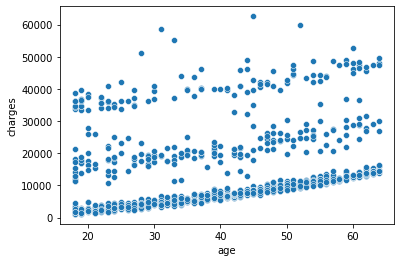

In [12]:
sns.scatterplot(data=dummies_df, x='age', y='charges')

**Nhận xét:**
- Qua biểu đồ ta thấy được chi phí sử dụng dịch vụ y tế có xu hướng tăng theo độ tuổi, nó cũng chia thành 3 cụm riêng biệt. Để hiểu rõ hơn từng cụm, chúng ta xem xét kết hợp với các thuộc tính khác nữa ở các bước dưới

<AxesSubplot:xlabel='age', ylabel='charges'>

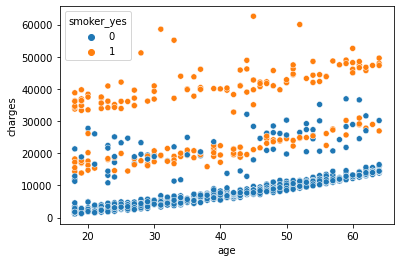

In [13]:
sns.scatterplot(data=dummies_df, x='age', y='charges', hue = 'smoker_yes')

**Nhận xét:**

Sau khi kết hợp với thuộc tính `Smoker` thì ta thấy được 3 cụm riêng biệt đó là:
- Cụm có chi phí thấp gồm những người không hút thuốc
- Cụm có chi phí cao gồm những người hút thuốc
- Cụm có chi phí trung bình gồm những người hút thuốc và những người không hút thuốc

Và có thể thấy từng cụm có quan hệ tuyến tính, tăng dần về những người lớn tuổi

### Relationship between `bmi` and `charges`, and the effect of smoker on that tie 

<AxesSubplot:xlabel='bmi', ylabel='charges'>

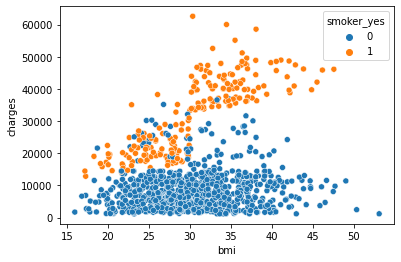

In [14]:
sns.scatterplot(data=dummies_df, x='bmi', y='charges', hue='smoker_yes')

**Nhận xét:**

Từ biểu đồ này ta thấy rằng:
- Chi phí của những người không hút thuốc có xu hướng tăng lên một chút khi chỉ số bmi tăng
- Chi phí của những người hút thuốc có xu hướng tăng mạnh khi chỉ số bmi tăng

Để xem xét rõ ràng hơn, ta vẽ thêm 2 đường hồi quy tương ứng với người hút thuốc và người không hút thuốc

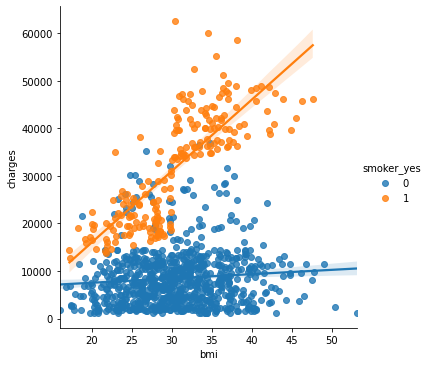

In [15]:
sns.lmplot(x="bmi", y="charges", hue="smoker_yes", data=dummies_df)

Ta thấy được đường hồi quy ứng với những người hút thuốc có độ dốc lớn hơn so với những người không hút thuốc

### Relationship between `smoker` and `charges`

<AxesSubplot:xlabel='smoker_yes', ylabel='charges'>

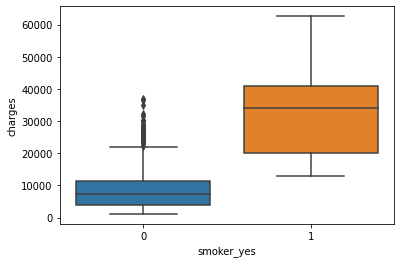

In [16]:
sns.boxplot(data=dummies_df, x='smoker_yes', y='charges')

**Nhận xét:**

Qua biểu đồ này và các biểu đồ trên ta thấy được `Smoker` có ảnh hưởng rất lớn đến chi phí sử dụng dịch vụ y tế. Những người hút thuốc phải trả cao hơn nhiều so với những người không hút thuốc

## Data Splitting

In [17]:
df_X = df.drop('charges',axis=1)
df_y = df['charges']

In [18]:
train_X, val_X, train_y, val_y = train_test_split(df_X, df_y, test_size=0.2, random_state=0)

## Model Bulding

In [19]:
eadc = EncoderAddDropCol()
scaler = StandardScaler()

In [20]:
eadc1 = EncoderAddDropCol()
scaler1 = StandardScaler()

### Linear Regression

In [21]:
linreg = LinearRegression()
linreg_pipe = make_pipeline(eadc,scaler,linreg)

### Random Forest

In [22]:
random_forest = RandomForestRegressor()
ranfor_pipe = make_pipeline(eadc1,scaler1,random_forest)

## Model Training

### Linear Regression

In [23]:
linreg_pipe.fit(train_X, train_y)
print('Train score:',linreg_pipe.score(train_X, train_y))
print('Validation score:',linreg_pipe.score(val_X, val_y))

Train score: 0.830395020080438
Validation score: 0.8602592522357086


### Random Forest Regression

In [24]:

train_errs = []
val_errs = []
num_estimators = [50, 75, 100, 125, 150]
max_depths = [16, 32, 64, 128, 256]
best_val_err = float('inf'); best_num = None; best_depth = None;

for num_estimator in num_estimators:
    for max_depth in max_depths:
        ranfor_pipe.set_params(randomforestregressor__n_estimators = num_estimator, randomforestregressor__max_depth = max_depth)
        ranfor_pipe.fit(train_X, train_y)

        train_err = 1-ranfor_pipe.score(train_X, train_y)
        train_errs.append(train_err)
        val_err = 1-ranfor_pipe.score(val_X, val_y)
        val_errs.append(val_err)
        

        if val_err * 100 < best_val_err:
            best_val_err = val_err
            best_num = num_estimator
            best_depth = max_depth


In [25]:
ranfor_pipe.set_params(randomforestregressor__n_estimators = best_num, randomforestregressor__max_depth = best_depth)
print('Train score:',ranfor_pipe.score(train_X, train_y))
print('Validation score:',ranfor_pipe.score(val_X, val_y))

Train score: 0.9746256421135879
Validation score: 0.8400741779491148


## Analysis Insights Checking

In [26]:
# find out which are unsignificant features
def refineFeature(model, train_X, train_y, val_X, val_y, checklist=None, epsilon = 0, fullfeature_score=None):
    if isinstance(checklist,list):
        feature_tocheck = checklist
    else:
        return -1
    trainval_score = None
    unsignificant = []
    
    print('Prev score:', fullfeature_score)
    print('Epsilon:', epsilon)
    print('-'*50)
    
    for feature in feature_tocheck:
        print('Without \'{}\':'.format(feature))
        model.set_params(encoderadddropcol__dropcols=feature)
        model.fit(train_X, train_y)
        
        trainval_score = model.score(val_X, val_y)
        diff = abs(trainval_score - fullfeature_score)
        if diff < epsilon:
            unsignificant.append(feature)
        print('New score:', trainval_score)
        print('Difference:', diff)
        print('-'*50)
    # Conclusion
    print('====> Unsignificant feature list: ', unsignificant)
    return unsignificant

### Linear Regression

In [27]:
fullfeature_score = linreg_pipe.score(val_X, val_y)
checklist = ['age','sex','bmi','children','smoker','region','smoke_bmi']
unsignificant_linreg = refineFeature(linreg_pipe, train_X, train_y, val_X, val_y, 
                              checklist=checklist, epsilon = 0.01 , fullfeature_score=fullfeature_score)

Prev score: 0.8602592522357086
Epsilon: 0.01
--------------------------------------------------
Without 'age':
New score: 0.7595965703187375
Difference: 0.10066268191697114
--------------------------------------------------
Without 'sex':
New score: 0.8598900615903153
Difference: 0.0003691906453933136
--------------------------------------------------
Without 'bmi':
New score: 0.8603182772642691
Difference: 5.9025028560477644e-05
--------------------------------------------------
Without 'children':
New score: 0.8597391121354709
Difference: 0.0005201401002377093
--------------------------------------------------
Without 'smoker':
New score: 0.8384829562492857
Difference: 0.021776295986422944
--------------------------------------------------
Without 'region':
New score: 0.8609235301414888
Difference: 0.000664277905780164
--------------------------------------------------
Without 'smoke_bmi':
New score: 0.7538700980226231
Difference: 0.10638915421308559
---------------------------------

### Random Forest

In [28]:
fullfeature_score = ranfor_pipe.score(val_X, val_y)
checklist = ['age','sex','bmi','children','smoker','region','smoke_bmi']
unsignificant_ranfor = refineFeature(ranfor_pipe, train_X, train_y, val_X, val_y, 
                              checklist=checklist, epsilon = 0.01 , fullfeature_score=fullfeature_score)

Prev score: 0.8400741779491148
Epsilon: 0.01
--------------------------------------------------
Without 'age':
New score: 0.7119136630173389
Difference: 0.12816051493177583
--------------------------------------------------
Without 'sex':
New score: 0.8463700608819789
Difference: 0.006295882932864094
--------------------------------------------------
Without 'bmi':
New score: 0.8012880201575481
Difference: 0.03878615779156669
--------------------------------------------------
Without 'children':
New score: 0.8169828482864632
Difference: 0.023091329662651594
--------------------------------------------------
Without 'smoker':
New score: 0.8298930580250687
Difference: 0.010181119924046023
--------------------------------------------------
Without 'region':
New score: 0.8306453616747499
Difference: 0.00942881627436487
--------------------------------------------------
Without 'smoke_bmi':
New score: 0.841088780135502
Difference: 0.00101460218638727
----------------------------------------

## Testing

In [29]:
test_df = pd.read_csv('test.csv')

In [30]:
test_X = test_df.drop('charges',axis=1)
test_y = test_df['charges']

### Linear Regression

In [31]:
eadc = EncoderAddDropCol(dropcols=unsignificant_linreg)
scaler = StandardScaler()
linreg = LinearRegression()
pipe = make_pipeline(eadc, scaler, linreg)

pipe.fit(df_X, df_y)
print('Train.csv Score:', pipe.score(df_X, df_y))
print('Test.csv score:', pipe.score(test_X,test_y))

Train.csv Score: 0.8320841714457461
Test.csv score: 0.8478662021721435


### Random Forest

In [32]:
eadc = EncoderAddDropCol(dropcols=unsignificant_ranfor)
scaler = StandardScaler()
ranfor= RandomForestRegressor()
ranfor_pipe = make_pipeline(eadc, scaler, ranfor)
ranfor_pipe.set_params(randomforestregressor__n_estimators = best_num, randomforestregressor__max_depth = best_depth)


ranfor_pipe.fit(df_X, df_y)
print('Train.csv Score:', ranfor_pipe.score(df_X, df_y))
print('Test.csv score:', ranfor_pipe.score(test_X,test_y))

Train.csv Score: 0.9729337862533126
Test.csv score: 0.8408823507138184


## Conclusion

### Model Analysis : Linear Regression

#### Standardized Data

In [33]:
print('intercept:',pipe['linearregression'].intercept_)
for feature,coef in zip(eadc.transform(df_X).columns,pipe['linearregression'].coef_):
    print(feature,':',coef)

intercept: 13267.935817337988
age : 3803.476866938462
bmi : -8561.217170639211
children : 18583.615870461967


**Đây là kết quả với dữ liệu đã chuẩn hóa nên tương đối khó giải thích các hệ số**

#### Unstandardized Data

In [34]:
noscale_pipe = make_pipeline(eadc,linreg)
noscale_pipe.fit(df_X, df_y)
print('Train.csv Score:', noscale_pipe.score(df_X, df_y))
print('Test.csv score:', noscale_pipe.score(test_X,test_y))

Train.csv Score: 0.744158565857672
Test.csv score: 0.7653688584061045


In [35]:
print('intercept:', noscale_pipe['linearregression'].intercept_)
for feature,coef in zip(eadc.transform(df_X).columns,noscale_pipe['linearregression'].coef_):
    print(feature,':',coef)

intercept: -12268.326378050355
age : 260.0084998743513
bmi : 327.5784444151295
children : 435.24021194005644
smoker_yes : 23632.639999737334


- Mỗi **1 tuổi** sẽ làm **tăng $\approx$271$\$$** chi phí y tế cá nhân

- Với những người hút thuốc, mỗi **1 điểm chỉ số BMI** sẽ làm **tăng $\approx$1471$\$$** chi phí y tế cá nhân.
Vì chỉ số bmi thường lớn nên hệ số âm của `smoker_yes` để điều chỉnh lại chi phí cá nhân cho phù hợp